# Problem 1: Convolutional Neural Network

# Intro

We will be tackling a straightforward image classification task using the CIFAR-10 dataset. Our goal is to build a CNN model that can accurately classify the images into their respective categories.


# 0. Warm-up

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.Tensor``.

For vision, PyTorch has a package called ``torchvision``, 
that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., ``torchvision.datasets`` 
and ``torch.utils.data.DataLoader``.
This provides a huge convenience and avoids writing boilerplate code.

In [2]:
%matplotlib inline

# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from matplotlib import cm

## Recap on MNIST Dataset

The built-in datasets library in the package `torchvision` will automatically download some dataset if you set `download=True` when initializing the dataset.

In [3]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, 
                                transform=transforms.ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, 
                               transform=transforms.ToTensor())
print("Print the training dataset:\n ", mnist_trainset)
print("Print the testing dataset:\n ", mnist_testset)

100%|██████████| 9912422/9912422 [00:00<00:00, 383879738.92it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 11702801.07it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 102233493.92it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 15981987.22it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Print the training dataset:
  Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Print the testing dataset:
  Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


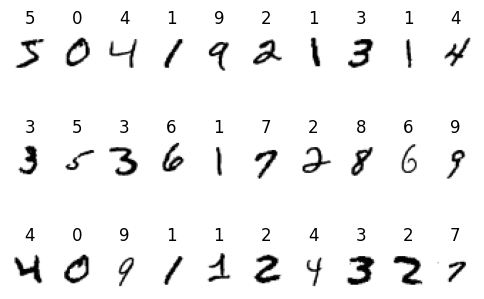

In [4]:
fig, axs = plt.subplots(3, 10, figsize = (6, 4))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
  ax.imshow(mnist_trainset[i][0][0], cmap=cm.gray_r)
  ax.axis('off')
  ax.set_title('{}'.format(mnist_trainset[i][1]))

In [5]:
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=4, shuffle=True) # creates a data loader for the MNIST training set
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=1, shuffle=False)
print(train_loader)
print(test_loader)

for batch_id, (data, label) in enumerate(train_loader):
  print('batch_id:', batch_id)
  print(data.shape)
  print(label.shape)
  break

batch_id: 0
torch.Size([4, 1, 28, 28])
torch.Size([4])


## CIFAR-10 Dataset

Follow the above instructions on MNIST dataset, write code to load and visualize the CIFAR-10 dataset in the similar manner.

CIFAR-10 dataset has the classes (listed below): ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size $3 \times 32 \times 32$, i.e. 3-channel color images of $32 \times 32$ pixels in size. 

<!-- <h4>Note:</h4>
The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].

1.   List item
2.   List item -->



In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 
           'ship', 'truck')
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, 
                                transform=transforms.ToTensor())
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, 
                               transform=transforms.ToTensor())
print("Print the training dataset:\n ", cifar_trainset)
print("Print the testing dataset:\n ", cifar_testset)

train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=False)

100%|██████████| 170498071/170498071 [00:13<00:00, 13105828.80it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Print the training dataset:
  Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Print the testing dataset:
  Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


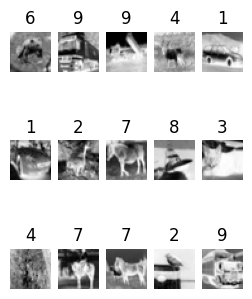

In [7]:
def cifar_imshow(img):
  npimg = img.numpy()
  return np.transpose(npimg, (1, 2, 0)) # reorganize the channel

# TODO: visualize some samples in the CIFAR-10 dataset
fig, axs = plt.subplots(3, 5, figsize = (3, 4))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
  ax.imshow(cifar_trainset[i][0][0], cmap=cm.gray_r)
  ax.axis('off')
  ax.set_title('{}'.format(cifar_trainset[i][1]))

# ENDS HERE

In [8]:
for batch_id, (data, label) in enumerate(train_loader):
  print('batch_id:', batch_id)
  print(data.shape)
  print(label.shape)
  break

batch_id: 0
torch.Size([4, 3, 32, 32])
torch.Size([4])


# 1-a. Define Convolutional Neural Network



In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## CNN Model

This is a very standard CNN pytorch model, the layers are already defined for you, in constrast with the `nn.Sequential()` method we taught in tutorial, we will be using another way to define our model:

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Read through official documentation: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html 
        # and make sure you understand the concept of 2D convolution and Conv2d layer's definition
        # Here is also some cool animation: https://towardsdatascience.com/conv2d-to-finally-understand-what-happens-in-the-forward-pass-1bbaafb0b148
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        output_dim_after_conv = 400 # total number of elements in the output
        output_dim_after_fc = 10 # number of output nodes in the final fully connected layer
        
        self.fc1 = nn.Linear(output_dim_after_conv, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_dim_after_fc)

    def forward(self, x):
        # TODO: build your forward function
        # 1. First pass the x through the first conv layer followed by relu then pooling
        x = self.pool(F.relu(self.conv1(x)))
        # 2. Then pass the output of step 1 through the second conv layer followed by relu then pooling
        x = self.pool(F.relu(self.conv2(x)))
        # 3. (important) Since we are now moving onto fully connected layer, we need to flatten the tensor,
        # 3. use `x = torch.flatten(x, 1)` with the output from step 2
        x = torch.flatten(x, 1)
        # 4 Finally pass the output of step 3 into `fc1`, `fc2` and `fc3 (remeber the relu!)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # this is the output layer, so no ReLU
        return x

my_cnn = Net().to(device)  # operate on GPU

After finishing the TODO in `forward()` try to run the next code block.
```
Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
```
You should get a exact same output as above with `print(my_cnn)`.

In [11]:
print(my_cnn)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Training Loop

Define your training loop, it should looks very similiar (almost the same) to what you did for MLP in hw2:

In [12]:
def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.7) 

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    train_loss_history = []
    valid_loss_history = []
    valid_accuracy_history = []

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        train_loss_history.append(mean_train_loss)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        val_accuracy = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

                _, predicted = torch.max(pred.data, 1)
                val_accuracy.append((predicted == y).sum().item() / predicted.size(0))
            loss_record.append(loss.item())

        mean_valid_loss = sum(loss_record)/len(loss_record)
        valid_loss_history.append(mean_valid_loss)

        mean_valid_accuracy = sum(val_accuracy)/len(val_accuracy)
        valid_accuracy_history.append(mean_valid_accuracy)
        print(mean_valid_accuracy)

    return train_loss_history, valid_loss_history, valid_accuracy_history


In [13]:
config = { # do not modify
    'seed': 5201314,      # Your seed number, you can pick your lucky number. :)
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 250,      # Number of epochs.            
    'batch_size': 256, 
    'learning_rate': 0.01,              
    'early_stop': 25,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

In [14]:
cifar_train_data, cifar_valid_data = random_split(cifar_trainset, [1-config['valid_ratio'], config['valid_ratio']])

train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=config['batch_size'], shuffle=True)
valid_loader = torch.utils.data.DataLoader(cifar_valid_data, batch_size=config['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=config['batch_size'], shuffle=False)

In [15]:
trainer(train_loader, valid_loader, my_cnn, config, device)

Epoch [1/250]: 100%|██████████| 196/196 [00:17<00:00, 11.00it/s, loss=2.3]


0.1044921875


Epoch [2/250]: 100%|██████████| 196/196 [00:10<00:00, 18.25it/s, loss=2.3]


0.139453125


Epoch [3/250]: 100%|██████████| 196/196 [00:11<00:00, 17.40it/s, loss=2.29]


0.1416015625


Epoch [4/250]: 100%|██████████| 196/196 [00:10<00:00, 18.45it/s, loss=2.12]


0.2095703125


Epoch [5/250]: 100%|██████████| 196/196 [00:10<00:00, 18.54it/s, loss=1.98]


0.2857421875


Epoch [6/250]: 100%|██████████| 196/196 [00:10<00:00, 18.67it/s, loss=1.92]


0.28525390625


Epoch [7/250]: 100%|██████████| 196/196 [00:10<00:00, 18.57it/s, loss=1.77]


0.35771484375


Epoch [8/250]: 100%|██████████| 196/196 [00:10<00:00, 18.23it/s, loss=1.69]


0.3685546875


Epoch [9/250]: 100%|██████████| 196/196 [00:10<00:00, 18.69it/s, loss=1.7]


0.36728515625


Epoch [10/250]: 100%|██████████| 196/196 [00:10<00:00, 18.59it/s, loss=1.61]


0.435546875


Epoch [11/250]: 100%|██████████| 196/196 [00:10<00:00, 18.54it/s, loss=1.62]


0.430078125


Epoch [12/250]: 100%|██████████| 196/196 [00:10<00:00, 18.49it/s, loss=1.62]


0.478125


Epoch [13/250]: 100%|██████████| 196/196 [00:10<00:00, 18.64it/s, loss=1.63]


0.49375


Epoch [14/250]: 100%|██████████| 196/196 [00:10<00:00, 18.16it/s, loss=1.29]


0.47841796875


Epoch [15/250]: 100%|██████████| 196/196 [00:10<00:00, 18.10it/s, loss=1.32]


0.47158203125


Epoch [16/250]: 100%|██████████| 196/196 [00:10<00:00, 18.40it/s, loss=1.23]


0.4912109375


Epoch [17/250]: 100%|██████████| 196/196 [00:10<00:00, 18.53it/s, loss=1.42]


0.50205078125


Epoch [18/250]: 100%|██████████| 196/196 [00:10<00:00, 18.58it/s, loss=1.27]


0.51142578125


Epoch [19/250]: 100%|██████████| 196/196 [00:10<00:00, 18.56it/s, loss=1.29]


0.525


Epoch [20/250]: 100%|██████████| 196/196 [00:10<00:00, 18.72it/s, loss=1.14]


0.54228515625


Epoch [21/250]: 100%|██████████| 196/196 [00:10<00:00, 18.32it/s, loss=1.32]


0.55205078125


Epoch [22/250]: 100%|██████████| 196/196 [00:10<00:00, 19.09it/s, loss=1.49]


0.55380859375


Epoch [23/250]: 100%|██████████| 196/196 [00:10<00:00, 18.96it/s, loss=1.17]


0.5533203125


Epoch [24/250]: 100%|██████████| 196/196 [00:10<00:00, 19.17it/s, loss=1.08]


0.58095703125


Epoch [25/250]: 100%|██████████| 196/196 [00:10<00:00, 19.09it/s, loss=1.29]


0.58916015625


Epoch [26/250]: 100%|██████████| 196/196 [00:10<00:00, 19.06it/s, loss=1.15]


0.5845703125


Epoch [27/250]: 100%|██████████| 196/196 [00:10<00:00, 19.05it/s, loss=1.37]


0.5919921875


Epoch [28/250]: 100%|██████████| 196/196 [00:10<00:00, 18.26it/s, loss=1.15]


0.585546875


Epoch [29/250]: 100%|██████████| 196/196 [00:10<00:00, 19.31it/s, loss=1.18]


0.60537109375


Epoch [30/250]: 100%|██████████| 196/196 [00:10<00:00, 19.27it/s, loss=1.3]


0.59736328125


Epoch [31/250]: 100%|██████████| 196/196 [00:10<00:00, 18.94it/s, loss=1.17]


0.6072265625


Epoch [32/250]: 100%|██████████| 196/196 [00:10<00:00, 19.28it/s, loss=0.966]


0.60341796875


Epoch [33/250]: 100%|██████████| 196/196 [00:10<00:00, 19.37it/s, loss=1.03]


0.60986328125


Epoch [34/250]: 100%|██████████| 196/196 [00:10<00:00, 18.79it/s, loss=0.97]


0.62509765625


Epoch [35/250]: 100%|██████████| 196/196 [00:10<00:00, 18.45it/s, loss=1.06]


0.626953125


Epoch [36/250]: 100%|██████████| 196/196 [00:10<00:00, 18.94it/s, loss=0.954]


0.63974609375


Epoch [37/250]: 100%|██████████| 196/196 [00:10<00:00, 18.95it/s, loss=0.989]


0.64560546875


Epoch [38/250]: 100%|██████████| 196/196 [00:10<00:00, 19.08it/s, loss=0.799]


0.61923828125


Epoch [39/250]: 100%|██████████| 196/196 [00:10<00:00, 18.99it/s, loss=1.13]


0.61083984375


Epoch [40/250]: 100%|██████████| 196/196 [00:10<00:00, 18.54it/s, loss=1.11]


0.65380859375


Epoch [41/250]: 100%|██████████| 196/196 [00:10<00:00, 18.37it/s, loss=0.881]


0.653515625


Epoch [42/250]: 100%|██████████| 196/196 [00:10<00:00, 18.35it/s, loss=0.962]


0.6712890625


Epoch [43/250]: 100%|██████████| 196/196 [00:10<00:00, 18.49it/s, loss=1.08]


0.6513671875


Epoch [44/250]: 100%|██████████| 196/196 [00:10<00:00, 18.53it/s, loss=0.882]


0.65341796875


Epoch [45/250]: 100%|██████████| 196/196 [00:10<00:00, 18.97it/s, loss=1.15]


0.666015625


Epoch [46/250]: 100%|██████████| 196/196 [00:10<00:00, 18.89it/s, loss=1.22]


0.6658203125


Epoch [47/250]: 100%|██████████| 196/196 [00:10<00:00, 18.83it/s, loss=0.816]


0.67392578125


Epoch [48/250]: 100%|██████████| 196/196 [00:10<00:00, 18.45it/s, loss=0.773]


0.6837890625


Epoch [49/250]: 100%|██████████| 196/196 [00:10<00:00, 18.32it/s, loss=0.743]


0.685546875


Epoch [50/250]: 100%|██████████| 196/196 [00:10<00:00, 18.54it/s, loss=1.06]


0.67431640625


Epoch [51/250]: 100%|██████████| 196/196 [00:10<00:00, 18.32it/s, loss=0.975]


0.6697265625


Epoch [52/250]: 100%|██████████| 196/196 [00:10<00:00, 18.60it/s, loss=1.02]


0.68798828125


Epoch [53/250]: 100%|██████████| 196/196 [00:10<00:00, 18.45it/s, loss=1.06]


0.687109375


Epoch [54/250]: 100%|██████████| 196/196 [00:10<00:00, 17.89it/s, loss=0.89]


0.69736328125


Epoch [55/250]: 100%|██████████| 196/196 [00:10<00:00, 18.11it/s, loss=0.839]


0.69501953125


Epoch [56/250]: 100%|██████████| 196/196 [00:11<00:00, 17.65it/s, loss=0.971]


0.6923828125


Epoch [57/250]: 100%|██████████| 196/196 [00:10<00:00, 18.22it/s, loss=0.904]


0.68818359375


Epoch [58/250]: 100%|██████████| 196/196 [00:10<00:00, 18.58it/s, loss=0.821]


0.69033203125


Epoch [59/250]: 100%|██████████| 196/196 [00:10<00:00, 18.76it/s, loss=0.708]


0.71328125


Epoch [60/250]: 100%|██████████| 196/196 [00:10<00:00, 18.53it/s, loss=0.764]


0.68359375


Epoch [61/250]: 100%|██████████| 196/196 [00:11<00:00, 17.34it/s, loss=0.722]


0.6962890625


Epoch [62/250]: 100%|██████████| 196/196 [00:11<00:00, 17.09it/s, loss=0.776]


0.72314453125


Epoch [63/250]: 100%|██████████| 196/196 [00:11<00:00, 16.93it/s, loss=0.83]


0.723828125


Epoch [64/250]: 100%|██████████| 196/196 [00:11<00:00, 17.50it/s, loss=0.675]


0.6943359375


Epoch [65/250]: 100%|██████████| 196/196 [00:10<00:00, 17.88it/s, loss=1.08]


0.7130859375


Epoch [66/250]: 100%|██████████| 196/196 [00:10<00:00, 18.19it/s, loss=0.881]


0.7283203125


Epoch [67/250]: 100%|██████████| 196/196 [00:10<00:00, 18.01it/s, loss=0.744]


0.733203125


Epoch [68/250]: 100%|██████████| 196/196 [00:10<00:00, 18.04it/s, loss=0.468]


0.730078125


Epoch [69/250]: 100%|██████████| 196/196 [00:11<00:00, 17.63it/s, loss=0.727]


0.7458984375


Epoch [70/250]: 100%|██████████| 196/196 [00:10<00:00, 18.01it/s, loss=0.553]


0.75068359375


Epoch [71/250]: 100%|██████████| 196/196 [00:10<00:00, 18.36it/s, loss=0.679]


0.762109375


Epoch [72/250]: 100%|██████████| 196/196 [00:10<00:00, 18.36it/s, loss=0.769]


0.75419921875


Epoch [73/250]: 100%|██████████| 196/196 [00:10<00:00, 18.14it/s, loss=0.794]


0.74619140625


Epoch [74/250]: 100%|██████████| 196/196 [00:11<00:00, 17.48it/s, loss=0.724]


0.762109375


Epoch [75/250]: 100%|██████████| 196/196 [00:11<00:00, 17.57it/s, loss=0.708]


0.75859375


Epoch [76/250]: 100%|██████████| 196/196 [00:11<00:00, 17.60it/s, loss=0.767]


0.75927734375


Epoch [77/250]: 100%|██████████| 196/196 [00:10<00:00, 18.25it/s, loss=0.604]


0.76865234375


Epoch [78/250]: 100%|██████████| 196/196 [00:10<00:00, 18.14it/s, loss=0.544]


0.7767578125


Epoch [79/250]: 100%|██████████| 196/196 [00:11<00:00, 17.78it/s, loss=0.537]


0.768359375


Epoch [80/250]: 100%|██████████| 196/196 [00:10<00:00, 17.83it/s, loss=0.916]


0.75556640625


Epoch [81/250]: 100%|██████████| 196/196 [00:10<00:00, 17.90it/s, loss=0.48]


0.763671875


Epoch [82/250]: 100%|██████████| 196/196 [00:10<00:00, 17.82it/s, loss=0.724]


0.78359375


Epoch [83/250]: 100%|██████████| 196/196 [00:11<00:00, 17.74it/s, loss=0.751]


0.77109375


Epoch [84/250]: 100%|██████████| 196/196 [00:10<00:00, 18.00it/s, loss=0.683]


0.771484375


Epoch [85/250]: 100%|██████████| 196/196 [00:10<00:00, 17.84it/s, loss=0.65]


0.75419921875


Epoch [86/250]: 100%|██████████| 196/196 [00:11<00:00, 17.76it/s, loss=0.677]


0.77412109375


Epoch [87/250]: 100%|██████████| 196/196 [00:10<00:00, 17.91it/s, loss=0.632]


0.77685546875


Epoch [88/250]: 100%|██████████| 196/196 [00:10<00:00, 17.90it/s, loss=0.6]


0.76435546875


Epoch [89/250]: 100%|██████████| 196/196 [00:11<00:00, 17.74it/s, loss=0.623]


0.77158203125


Epoch [90/250]: 100%|██████████| 196/196 [00:11<00:00, 17.42it/s, loss=0.771]


0.803125


Epoch [91/250]: 100%|██████████| 196/196 [00:10<00:00, 18.05it/s, loss=0.551]


0.80498046875


Epoch [92/250]: 100%|██████████| 196/196 [00:10<00:00, 17.90it/s, loss=0.542]


0.815234375


Epoch [93/250]: 100%|██████████| 196/196 [00:10<00:00, 17.86it/s, loss=0.443]


0.80869140625


Epoch [94/250]: 100%|██████████| 196/196 [00:10<00:00, 18.06it/s, loss=0.686]


0.79169921875


Epoch [95/250]: 100%|██████████| 196/196 [00:10<00:00, 18.16it/s, loss=0.773]


0.79775390625


Epoch [96/250]: 100%|██████████| 196/196 [00:10<00:00, 18.20it/s, loss=0.489]


0.805078125


Epoch [97/250]: 100%|██████████| 196/196 [00:10<00:00, 17.91it/s, loss=0.467]


0.8251953125


Epoch [98/250]: 100%|██████████| 196/196 [00:10<00:00, 17.92it/s, loss=0.466]


0.81552734375


Epoch [99/250]: 100%|██████████| 196/196 [00:11<00:00, 17.73it/s, loss=0.55]


0.8056640625


Epoch [100/250]: 100%|██████████| 196/196 [00:10<00:00, 17.99it/s, loss=0.538]


0.82314453125


Epoch [101/250]: 100%|██████████| 196/196 [00:11<00:00, 17.78it/s, loss=0.539]


0.8201171875


Epoch [102/250]: 100%|██████████| 196/196 [00:11<00:00, 17.73it/s, loss=0.675]


0.8111328125


Epoch [103/250]: 100%|██████████| 196/196 [00:10<00:00, 18.04it/s, loss=0.519]


0.8255859375


Epoch [104/250]: 100%|██████████| 196/196 [00:11<00:00, 17.52it/s, loss=0.571]


0.83427734375


Epoch [105/250]: 100%|██████████| 196/196 [00:10<00:00, 17.96it/s, loss=0.574]


0.78095703125


Epoch [106/250]: 100%|██████████| 196/196 [00:10<00:00, 18.11it/s, loss=0.74]


0.82470703125


Epoch [107/250]: 100%|██████████| 196/196 [00:10<00:00, 18.05it/s, loss=0.505]


0.800390625


Epoch [108/250]: 100%|██████████| 196/196 [00:10<00:00, 18.15it/s, loss=0.436]


0.8443359375


Epoch [109/250]: 100%|██████████| 196/196 [00:10<00:00, 18.20it/s, loss=0.582]


0.83662109375


Epoch [110/250]: 100%|██████████| 196/196 [00:10<00:00, 17.84it/s, loss=0.397]


0.8033203125


Epoch [111/250]: 100%|██████████| 196/196 [00:10<00:00, 18.05it/s, loss=0.446]


0.81484375


Epoch [112/250]: 100%|██████████| 196/196 [00:11<00:00, 17.69it/s, loss=0.583]


0.8408203125


Epoch [113/250]: 100%|██████████| 196/196 [00:11<00:00, 17.81it/s, loss=0.617]


0.8328125


Epoch [114/250]: 100%|██████████| 196/196 [00:11<00:00, 17.61it/s, loss=0.371]


0.84453125


Epoch [115/250]: 100%|██████████| 196/196 [00:10<00:00, 18.07it/s, loss=0.561]


0.8466796875


Epoch [116/250]: 100%|██████████| 196/196 [00:10<00:00, 18.19it/s, loss=0.376]


0.84404296875


Epoch [117/250]: 100%|██████████| 196/196 [00:11<00:00, 17.68it/s, loss=0.488]


0.8505859375


Epoch [118/250]: 100%|██████████| 196/196 [00:10<00:00, 17.98it/s, loss=0.282]


0.8376953125


Epoch [119/250]: 100%|██████████| 196/196 [00:11<00:00, 17.75it/s, loss=0.302]


0.84697265625


Epoch [120/250]: 100%|██████████| 196/196 [00:10<00:00, 17.98it/s, loss=0.502]


0.8392578125


Epoch [121/250]: 100%|██████████| 196/196 [00:10<00:00, 18.02it/s, loss=0.587]


0.87470703125


Epoch [122/250]: 100%|██████████| 196/196 [00:10<00:00, 18.06it/s, loss=0.39]


0.86396484375


Epoch [123/250]: 100%|██████████| 196/196 [00:10<00:00, 18.06it/s, loss=0.561]


0.839453125


Epoch [124/250]: 100%|██████████| 196/196 [00:11<00:00, 17.73it/s, loss=0.438]


0.8326171875


Epoch [125/250]: 100%|██████████| 196/196 [00:10<00:00, 18.03it/s, loss=0.425]


0.86298828125


Epoch [126/250]: 100%|██████████| 196/196 [00:10<00:00, 18.23it/s, loss=0.387]


0.85869140625


Epoch [127/250]: 100%|██████████| 196/196 [00:10<00:00, 18.12it/s, loss=0.47]


0.8712890625


Epoch [128/250]: 100%|██████████| 196/196 [00:10<00:00, 17.98it/s, loss=0.288]


0.86611328125


Epoch [129/250]: 100%|██████████| 196/196 [00:10<00:00, 18.01it/s, loss=0.432]


0.86611328125


Epoch [130/250]: 100%|██████████| 196/196 [00:10<00:00, 17.89it/s, loss=0.386]


0.83994140625


Epoch [131/250]: 100%|██████████| 196/196 [00:11<00:00, 17.30it/s, loss=0.382]


0.84189453125


Epoch [132/250]: 100%|██████████| 196/196 [00:10<00:00, 17.91it/s, loss=0.477]


0.88642578125


Epoch [133/250]: 100%|██████████| 196/196 [00:11<00:00, 17.80it/s, loss=0.398]


0.88046875


Epoch [134/250]: 100%|██████████| 196/196 [00:10<00:00, 17.82it/s, loss=0.514]


0.84462890625


Epoch [135/250]: 100%|██████████| 196/196 [00:10<00:00, 17.84it/s, loss=0.3]


0.878515625


Epoch [136/250]: 100%|██████████| 196/196 [00:11<00:00, 17.75it/s, loss=0.43]


0.8580078125


Epoch [137/250]: 100%|██████████| 196/196 [00:11<00:00, 17.70it/s, loss=0.384]


0.87919921875


Epoch [138/250]: 100%|██████████| 196/196 [00:11<00:00, 17.28it/s, loss=0.32]


0.8876953125


Epoch [139/250]: 100%|██████████| 196/196 [00:11<00:00, 17.68it/s, loss=0.391]


0.8517578125


Epoch [140/250]: 100%|██████████| 196/196 [00:10<00:00, 17.88it/s, loss=0.488]


0.89951171875


Epoch [141/250]: 100%|██████████| 196/196 [00:10<00:00, 17.82it/s, loss=0.273]


0.883984375


Epoch [142/250]: 100%|██████████| 196/196 [00:11<00:00, 17.66it/s, loss=0.412]


0.88115234375


Epoch [143/250]: 100%|██████████| 196/196 [00:11<00:00, 17.64it/s, loss=0.195]


0.88837890625


Epoch [144/250]: 100%|██████████| 196/196 [00:11<00:00, 17.49it/s, loss=0.644]


0.864453125


Epoch [145/250]: 100%|██████████| 196/196 [00:11<00:00, 17.74it/s, loss=0.22]


0.904296875


Epoch [146/250]: 100%|██████████| 196/196 [00:10<00:00, 17.95it/s, loss=0.445]


0.89990234375


Epoch [147/250]: 100%|██████████| 196/196 [00:10<00:00, 17.87it/s, loss=0.293]


0.8900390625


Epoch [148/250]: 100%|██████████| 196/196 [00:11<00:00, 17.51it/s, loss=0.374]


0.887109375


Epoch [149/250]: 100%|██████████| 196/196 [00:11<00:00, 17.70it/s, loss=0.35]


0.8810546875


Epoch [150/250]: 100%|██████████| 196/196 [00:11<00:00, 17.63it/s, loss=0.373]


0.8869140625


Epoch [151/250]: 100%|██████████| 196/196 [00:11<00:00, 17.63it/s, loss=0.328]


0.883984375


Epoch [152/250]: 100%|██████████| 196/196 [00:11<00:00, 17.27it/s, loss=0.174]


0.89287109375


Epoch [153/250]: 100%|██████████| 196/196 [00:11<00:00, 17.36it/s, loss=0.37]


0.8662109375


Epoch [154/250]: 100%|██████████| 196/196 [00:11<00:00, 17.57it/s, loss=0.33]


0.866015625


Epoch [155/250]: 100%|██████████| 196/196 [00:11<00:00, 17.40it/s, loss=0.331]


0.89345703125


Epoch [156/250]: 100%|██████████| 196/196 [00:11<00:00, 17.27it/s, loss=0.193]


0.90302734375


Epoch [157/250]: 100%|██████████| 196/196 [00:11<00:00, 17.19it/s, loss=0.219]


0.89990234375


Epoch [158/250]: 100%|██████████| 196/196 [00:11<00:00, 16.68it/s, loss=0.487]


0.8962890625


Epoch [159/250]: 100%|██████████| 196/196 [00:11<00:00, 17.27it/s, loss=0.235]


0.87841796875


Epoch [160/250]: 100%|██████████| 196/196 [00:11<00:00, 17.15it/s, loss=0.333]


0.9025390625


Epoch [161/250]: 100%|██████████| 196/196 [00:11<00:00, 16.65it/s, loss=0.194]


0.90634765625


Epoch [162/250]: 100%|██████████| 196/196 [00:11<00:00, 17.09it/s, loss=0.478]


0.83828125


Epoch [163/250]: 100%|██████████| 196/196 [00:11<00:00, 17.14it/s, loss=0.409]


0.8833984375


Epoch [164/250]: 100%|██████████| 196/196 [00:11<00:00, 17.33it/s, loss=0.314]


0.896875


Epoch [165/250]: 100%|██████████| 196/196 [00:11<00:00, 17.60it/s, loss=0.205]


0.914453125


Epoch [166/250]: 100%|██████████| 196/196 [00:11<00:00, 17.68it/s, loss=0.259]


0.88564453125


Epoch [167/250]: 100%|██████████| 196/196 [00:11<00:00, 17.58it/s, loss=0.352]


0.8771484375


Epoch [168/250]: 100%|██████████| 196/196 [00:11<00:00, 17.35it/s, loss=0.266]


0.86494140625


Epoch [169/250]: 100%|██████████| 196/196 [00:11<00:00, 17.34it/s, loss=0.401]


0.91484375


Epoch [170/250]: 100%|██████████| 196/196 [00:11<00:00, 17.45it/s, loss=0.202]


0.89580078125


Epoch [171/250]: 100%|██████████| 196/196 [00:11<00:00, 17.26it/s, loss=0.334]


0.92265625


Epoch [172/250]: 100%|██████████| 196/196 [00:11<00:00, 16.92it/s, loss=0.463]


0.834375


Epoch [173/250]: 100%|██████████| 196/196 [00:11<00:00, 17.34it/s, loss=0.305]


0.8736328125


Epoch [174/250]: 100%|██████████| 196/196 [00:11<00:00, 17.16it/s, loss=0.365]


0.9173828125


Epoch [175/250]: 100%|██████████| 196/196 [00:11<00:00, 17.08it/s, loss=0.387]


0.918359375


Epoch [176/250]: 100%|██████████| 196/196 [00:11<00:00, 17.21it/s, loss=0.185]


0.91708984375


Epoch [177/250]: 100%|██████████| 196/196 [00:11<00:00, 17.36it/s, loss=0.298]


0.9158203125


Epoch [178/250]: 100%|██████████| 196/196 [00:11<00:00, 17.63it/s, loss=0.474]


0.87421875


Epoch [179/250]: 100%|██████████| 196/196 [00:11<00:00, 17.17it/s, loss=0.217]


0.93818359375


Epoch [180/250]: 100%|██████████| 196/196 [00:11<00:00, 17.33it/s, loss=0.283]


0.91865234375


Epoch [181/250]: 100%|██████████| 196/196 [00:11<00:00, 17.34it/s, loss=0.182]


0.89609375


Epoch [182/250]: 100%|██████████| 196/196 [00:11<00:00, 17.41it/s, loss=0.331]


0.8576171875


Epoch [183/250]: 100%|██████████| 196/196 [00:11<00:00, 17.49it/s, loss=0.31]


0.8783203125


Epoch [184/250]: 100%|██████████| 196/196 [00:11<00:00, 17.43it/s, loss=0.32]


0.92412109375


Epoch [185/250]: 100%|██████████| 196/196 [00:11<00:00, 17.45it/s, loss=0.329]


0.9244140625


Epoch [186/250]: 100%|██████████| 196/196 [00:11<00:00, 17.17it/s, loss=0.329]


0.93984375


Epoch [187/250]: 100%|██████████| 196/196 [00:11<00:00, 17.52it/s, loss=0.265]


0.9240234375


Epoch [188/250]: 100%|██████████| 196/196 [00:11<00:00, 17.46it/s, loss=0.364]


0.86328125


Epoch [189/250]: 100%|██████████| 196/196 [00:11<00:00, 17.75it/s, loss=0.28]


0.908984375


Epoch [190/250]: 100%|██████████| 196/196 [00:11<00:00, 17.67it/s, loss=0.117]


0.93505859375


Epoch [191/250]: 100%|██████████| 196/196 [00:10<00:00, 18.13it/s, loss=0.3]


0.89794921875


Epoch [192/250]: 100%|██████████| 196/196 [00:10<00:00, 18.42it/s, loss=0.266]


0.92177734375


Epoch [193/250]: 100%|██████████| 196/196 [00:10<00:00, 17.86it/s, loss=0.125]


0.94140625


Epoch [194/250]: 100%|██████████| 196/196 [00:10<00:00, 17.97it/s, loss=0.312]


0.9279296875


Epoch [195/250]: 100%|██████████| 196/196 [00:10<00:00, 18.08it/s, loss=0.272]


0.9185546875


Epoch [196/250]: 100%|██████████| 196/196 [00:10<00:00, 18.02it/s, loss=0.277]


0.90537109375


Epoch [197/250]: 100%|██████████| 196/196 [00:10<00:00, 17.99it/s, loss=0.427]


0.90263671875


Epoch [198/250]: 100%|██████████| 196/196 [00:11<00:00, 17.66it/s, loss=0.228]


0.9271484375


Epoch [199/250]: 100%|██████████| 196/196 [00:11<00:00, 17.55it/s, loss=0.237]


0.92373046875


Epoch [200/250]: 100%|██████████| 196/196 [00:11<00:00, 17.00it/s, loss=0.134]


0.93525390625


Epoch [201/250]: 100%|██████████| 196/196 [00:11<00:00, 17.76it/s, loss=0.252]


0.9412109375


Epoch [202/250]: 100%|██████████| 196/196 [00:11<00:00, 17.57it/s, loss=0.11]


0.90576171875


Epoch [203/250]: 100%|██████████| 196/196 [00:11<00:00, 17.52it/s, loss=0.189]


0.94013671875


Epoch [204/250]: 100%|██████████| 196/196 [00:11<00:00, 17.65it/s, loss=0.387]


0.86767578125


Epoch [205/250]: 100%|██████████| 196/196 [00:11<00:00, 16.99it/s, loss=0.177]


0.926953125


Epoch [206/250]: 100%|██████████| 196/196 [00:11<00:00, 17.18it/s, loss=0.315]


0.92470703125


Epoch [207/250]: 100%|██████████| 196/196 [00:11<00:00, 16.96it/s, loss=0.147]


0.91103515625


Epoch [208/250]: 100%|██████████| 196/196 [00:11<00:00, 17.48it/s, loss=0.0893]


0.94521484375


Epoch [209/250]: 100%|██████████| 196/196 [00:11<00:00, 17.59it/s, loss=0.216]


0.92255859375


Epoch [210/250]: 100%|██████████| 196/196 [00:11<00:00, 17.63it/s, loss=0.159]


0.94208984375


Epoch [211/250]: 100%|██████████| 196/196 [00:11<00:00, 17.43it/s, loss=0.172]


0.92275390625


Epoch [212/250]: 100%|██████████| 196/196 [00:11<00:00, 17.46it/s, loss=0.333]


0.9333984375


Epoch [213/250]: 100%|██████████| 196/196 [00:11<00:00, 16.99it/s, loss=0.132]


0.9298828125


Epoch [214/250]: 100%|██████████| 196/196 [00:11<00:00, 17.10it/s, loss=0.109]


0.96318359375


Epoch [215/250]: 100%|██████████| 196/196 [00:11<00:00, 17.63it/s, loss=0.139]


0.93017578125


Epoch [216/250]: 100%|██████████| 196/196 [00:11<00:00, 17.35it/s, loss=0.122]


0.95498046875


Epoch [217/250]: 100%|██████████| 196/196 [00:11<00:00, 17.41it/s, loss=0.226]


0.91240234375


Epoch [218/250]: 100%|██████████| 196/196 [00:11<00:00, 17.24it/s, loss=0.121]


0.93974609375


Epoch [219/250]: 100%|██████████| 196/196 [00:11<00:00, 17.20it/s, loss=0.0884]


0.91943359375


Epoch [220/250]: 100%|██████████| 196/196 [00:11<00:00, 17.45it/s, loss=0.263]


0.92392578125


Epoch [221/250]: 100%|██████████| 196/196 [00:11<00:00, 17.52it/s, loss=0.26]


0.93876953125


Epoch [222/250]: 100%|██████████| 196/196 [00:11<00:00, 17.23it/s, loss=0.172]


0.92001953125


Epoch [223/250]: 100%|██████████| 196/196 [00:11<00:00, 17.17it/s, loss=0.128]


0.94609375


Epoch [224/250]: 100%|██████████| 196/196 [00:11<00:00, 17.18it/s, loss=0.254]


0.906640625


Epoch [225/250]: 100%|██████████| 196/196 [00:11<00:00, 17.28it/s, loss=0.13]


0.95419921875


Epoch [226/250]: 100%|██████████| 196/196 [00:11<00:00, 17.12it/s, loss=0.1]


0.9564453125


Epoch [227/250]: 100%|██████████| 196/196 [00:11<00:00, 16.87it/s, loss=0.197]


0.9177734375


Epoch [228/250]: 100%|██████████| 196/196 [00:11<00:00, 17.27it/s, loss=0.122]


0.9630859375


Epoch [229/250]: 100%|██████████| 196/196 [00:11<00:00, 17.31it/s, loss=0.135]


0.95830078125


Epoch [230/250]: 100%|██████████| 196/196 [00:11<00:00, 17.16it/s, loss=0.0952]


0.952734375


Epoch [231/250]: 100%|██████████| 196/196 [00:11<00:00, 17.28it/s, loss=0.124]


0.93623046875


Epoch [232/250]: 100%|██████████| 196/196 [00:11<00:00, 17.45it/s, loss=0.0961]


0.9294921875


Epoch [233/250]: 100%|██████████| 196/196 [00:11<00:00, 17.69it/s, loss=0.394]


0.891015625


Epoch [234/250]: 100%|██████████| 196/196 [00:11<00:00, 17.27it/s, loss=0.171]


0.94384765625


Epoch [235/250]: 100%|██████████| 196/196 [00:11<00:00, 17.36it/s, loss=0.0959]


0.93720703125


Epoch [236/250]: 100%|██████████| 196/196 [00:11<00:00, 17.31it/s, loss=0.26]


0.91669921875


Epoch [237/250]: 100%|██████████| 196/196 [00:11<00:00, 17.32it/s, loss=0.172]


0.9427734375


Epoch [238/250]: 100%|██████████| 196/196 [00:11<00:00, 17.08it/s, loss=0.0678]


0.9625


Epoch [239/250]: 100%|██████████| 196/196 [00:11<00:00, 17.21it/s, loss=0.144]


0.96181640625


Epoch [240/250]: 100%|██████████| 196/196 [00:11<00:00, 17.17it/s, loss=0.103]


0.9576171875


Epoch [241/250]: 100%|██████████| 196/196 [00:11<00:00, 16.96it/s, loss=0.28]


0.93623046875


Epoch [242/250]: 100%|██████████| 196/196 [00:11<00:00, 17.20it/s, loss=0.0654]


0.95888671875


Epoch [243/250]: 100%|██████████| 196/196 [00:11<00:00, 17.20it/s, loss=0.233]


0.905078125


Epoch [244/250]: 100%|██████████| 196/196 [00:11<00:00, 17.07it/s, loss=0.396]


0.92734375


Epoch [245/250]: 100%|██████████| 196/196 [00:11<00:00, 17.24it/s, loss=0.0807]


0.94658203125


Epoch [246/250]: 100%|██████████| 196/196 [00:11<00:00, 17.29it/s, loss=0.0562]


0.94677734375


Epoch [247/250]: 100%|██████████| 196/196 [00:11<00:00, 17.23it/s, loss=0.157]


0.93857421875


Epoch [248/250]: 100%|██████████| 196/196 [00:11<00:00, 17.01it/s, loss=0.166]


0.96494140625


Epoch [249/250]: 100%|██████████| 196/196 [00:11<00:00, 17.48it/s, loss=0.123]


0.96669921875


Epoch [250/250]: 100%|██████████| 196/196 [00:11<00:00, 17.49it/s, loss=0.0494]


0.9853515625


## Evaluation on CIFAR-10 Testing

Getting overall accuracy

In [16]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = my_cnn(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 57 %


Getting class-wise accuracies

In [17]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = my_cnn(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 60.7 %
Accuracy for class: car   is 69.8 %
Accuracy for class: bird  is 48.5 %
Accuracy for class: cat   is 39.8 %
Accuracy for class: deer  is 48.7 %
Accuracy for class: dog   is 47.4 %
Accuracy for class: frog  is 65.7 %
Accuracy for class: horse is 64.0 %
Accuracy for class: ship  is 72.4 %
Accuracy for class: truck is 59.8 %


# 1-b. Learning Cruves

Plot two plots of the CNN model: 
1. the learning curve (error versus epoch)
2. the accuracy curve (validation accuracy versus epoch)

Please use the configuration provided in the code to do the plotting.

In [1]:
def plot_learning_curve(train_loss_history, valid_loss_history, valid_accuracy_history):
    # Set up plot figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot learning curve (loss)
    ax1.plot(train_loss_history, label='Training Loss')
    ax1.plot(valid_loss_history, label='Validation Loss')
    ax1.set_title('Learning Curve (Loss)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # Plot validation accuracy
    ax2.plot(valid_accuracy_history, label='Validation Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    # Show plots
    plt.show()

# Call the plot_learning_curve function with your data
train_loss_history, valid_loss_history, valid_accuracy_history = trainer(train_loader, valid_loader, my_cnn, config, device)
plot_learning_curve(train_loss_history, valid_loss_history, valid_accuracy_history)


NameError: ignored

# 1-c. Try Different CNN Parameters
Try different CNN parameters/configurations/model architectures to see if you can reach 80\% accuracy on the CIFAR-10 testing set. Please briefly explain what you change and include the screenshot of model info (using `print(model)`) in the pdf.

In [19]:
# TODO 1-c
class your_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=64 * 8 * 8, out_features=512)
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.3)

        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        return x

your_config = {
    'seed': 8471220,      # Your seed number, you can pick your lucky number. :)
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 250,      # Number of epochs.            
    'batch_size': 256, 
    'learning_rate': 0.01,              
    'early_stop': 25,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

In [20]:
trainer(train_loader, valid_loader, your_cnn, your_config, device)

TypeError: ignored